In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import pandas_datareader as pdr
import seaborn as sns
sns.set()
from keras.utils import to_categorical
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow import keras
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline


In [2]:
# Function to Validate Tickers
# Code courtesy Gregory Rash

def validateTick(tick):
    
    # Try Inputting into Yahoo Stocks
    try:
        pdr.DataReader(f'{tick}','yahoo',date)
    
    # Raise Error if Invalid
    except:
        raise ValueError("Ticker Not Valid.")
        
# Function to Validate Date
def validate(date_text):
    
    # Try Check on Format
    try:
        datetime.strptime(date_text, '%Y-%m-%d')
        
    # Raise Error if Invalid
    except ValueError:
        raise ValueError("Incorrect data format, should be YYYY-MM-DD")
        
# Function to Validate Date
def validateShift(shift):
    shift = int(shift)
    # Try Check on Format
    try:
        if 0 > shift <= 365:
            pass
        
    # Raise Error if Invalid
    except ValueError:
        raise ValueError("Please enter a whole number.")

In [3]:
# Pick a Start Date
# Code courtesy Gregory Rash

date = input("Pick a start date for your analysis (YYYY-MM-DD): ")

# Validate Correct Date Format
validate(date)

Pick a start date for your analysis (YYYY-MM-DD):  2016-01-01


In [4]:
# Pick a Stock
# Code courtesy Gregory Rash

stock_selection = input("Pick a stock ticker for your analysis: ")

# Validate Correct Date Format
validateTick(stock_selection)

Pick a stock ticker for your analysis:  CME


In [5]:
# Pick Shift
# Code courtesy Gregory Rash

shift_selection = input("Pick how many days to shift your close values for your analysis: ")

# Validate Correct Date Format
validateShift(shift_selection)

Pick how many days to shift your close values for your analysis:  1


In [6]:
# Function to Create Stocks
# Code courtesy Gregory Rash

def stockCreation(date, stock_selection, days_shifted):
    
    # Read Stock Data
    globals()[stock_selection] = pdr.DataReader(f'{stock_selection}','yahoo',date)
    
    # Create Shifted Close Column
    globals()[stock_selection]["Shifted Close"] = globals()[stock_selection]["Adj Close"].shift(-int(days_shifted))
    
    # Drop Rows Without Shift Values
    globals()[stock_selection].drop(globals()[stock_selection].tail(int(days_shifted)).index, inplace = True) 
    
    # Empty List to Hold Profit or Loss
    profit_loss = []
    
    # Iterate Through DataFrame
    for x in range(len(globals()[stock_selection])):
        
        # Handle Profitable Days
        if globals()[stock_selection]["Shifted Close"][x] > globals()[stock_selection]["Adj Close"][x]:
            
            # Append "Profit" to Empty List
            profit_loss.append(1)
            
        # Handle Loss Days
        elif globals()[stock_selection]["Shifted Close"][x] < globals()[stock_selection]["Adj Close"][x]:
            
            # Append "Loss" to Empty List
            profit_loss.append(0)
            
        # Handle Push Days
        elif globals()[stock_selection]["Shifted Close"][x] == globals()[stock_selection]["Adj Close"][x]:
            
            # Append "Push" to Empty List
            profit_loss.append(2)
    
    # Create Profit/Loss Column
    globals()[stock_selection]["Profit_Loss"] = profit_loss
    
    # Create Returns Column
    globals()[stock_selection]['Returns'] = np.log(globals()[stock_selection]['Adj Close'] / globals()[stock_selection]['Adj Close'].shift(1))
    
    # Iterate to Create STD Columns
    for x in range(5, 20, 5):
        
        # Create STD Column Based on Iteration
        col_name = 'std_' + str(x)
        
        # Add STD Column to DataFrame
        globals()[stock_selection][col_name] = globals()[stock_selection]['Adj Close'].rolling(window=x).std()

    # Iterate to Create MA Columns
    for x in range(10, 30, 5):
        
        # Create MA Column Based on Iteration
        col_name = 'ma_' + str(x)
        
        # Add MA Column to DataFrame
        globals()[stock_selection][col_name] = globals()[stock_selection]['Adj Close'].rolling(window=x).mean()

    # Iterate to Create % Change Columns
    for x in range(3, 12, 3):
        
        # Create % Change Column Based on Iteration
        col_name = 'pct_' + str(x)
        
        # Add % Change Column to DataFrame
        globals()[stock_selection][col_name] = globals()[stock_selection]['Adj Close'].pct_change().rolling(window=x).sum()

    # Create VMA 4 Column
    col_name = 'vma_4'
    
    # Add VMA 4 Column to DataFrame
    globals()[stock_selection][col_name] = globals()[stock_selection]['Volume'].rolling(4).mean()

    # Create Intraday Column
    col_name = 'co'
    
    # Add Intraday Column to DataFrame
    globals()[stock_selection][col_name] = globals()[stock_selection]['Adj Close'] - globals()[stock_selection]['Open']
    
    # Drop All NaN's
    globals()[stock_selection].dropna(inplace=True)
    
    # Return DataFrame
    return globals()[stock_selection]

In [7]:
# Create Stock
stockdf = stockCreation(date, stock_selection, shift_selection)
stockdf.head()

,High,Low,Open,Close,Volume,Adj Close,Shifted Close,Profit_Loss,Returns,std_5,...,std_15,ma_10,ma_15,ma_20,ma_25,pct_3,pct_6,pct_9,vma_4,co
Date,,,,,,,,,,,,,,,,,,,,,
2016-02-08,90.669998,87.000000,88.410004,90.190002,2758100.0,75.330887,77.936836,1,0.018351,1.218740,...,2.022289,73.756442,72.653080,72.354897,72.608648,0.009896,0.004898,0.044908,2910525.0,-13.079117
2016-02-09,93.809998,89.050003,89.050003,93.309998,3233500.0,77.936836,75.614868,0,0.034008,2.126921,...,2.423534,74.336102,73.053999,72.620506,72.763668,0.078829,0.044054,0.075449,3200800.0,-11.113167
2016-02-10,93.489998,90.440002,93.029999,90.529999,2133700.0,75.614868,74.604225,0,-0.030246,2.154174,...,2.382844,74.654331,73.406474,72.757486,72.802423,0.023321,0.017951,0.041389,2785025.0,-17.415131
2016-02-11,90.550003,88.320000,88.360001,89.320000,1952800.0,74.604225,76.132721,1,-0.013456,1.512457,...,1.967143,74.840592,73.814632,72.972562,72.815453,-0.008565,0.001331,-0.003668,2519525.0,-13.755775
2016-02-12,91.290001,89.510002,90.919998,91.150002,1691200.0,76.132721,75.765213,0,0.020281,1.253418,...,1.863000,74.949174,74.169889,73.241928,72.936396,-0.022671,0.056159,0.021383,2252800.0,-14.787277


In [8]:
stockdf.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1264 entries, 2016-02-08 to 2021-02-12
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   High           1264 non-null   float64
 1   Low            1264 non-null   float64
 2   Open           1264 non-null   float64
 3   Close          1264 non-null   float64
 4   Volume         1264 non-null   float64
 5   Adj Close      1264 non-null   float64
 6   Shifted Close  1264 non-null   float64
 7   Profit_Loss    1264 non-null   int64  
 8   Returns        1264 non-null   float64
 9   std_5          1264 non-null   float64
 10  std_10         1264 non-null   float64
 11  std_15         1264 non-null   float64
 12  ma_10          1264 non-null   float64
 13  ma_15          1264 non-null   float64
 14  ma_20          1264 non-null   float64
 15  ma_25          1264 non-null   float64
 16  pct_3          1264 non-null   float64
 17  pct_6          1264 non-null   flo

In [9]:
#Prepare to assign X and y

stocktargets=stockdf['Profit_Loss']
stockdf=stockdf.drop(columns=['Profit_Loss'])
stockdf.head()

,High,Low,Open,Close,Volume,Adj Close,Shifted Close,Returns,std_5,std_10,std_15,ma_10,ma_15,ma_20,ma_25,pct_3,pct_6,pct_9,vma_4,co
Date,,,,,,,,,,,,,,,,,,,,
2016-02-08,90.669998,87.000000,88.410004,90.190002,2758100.0,75.330887,77.936836,0.018351,1.218740,1.268820,2.022289,73.756442,72.653080,72.354897,72.608648,0.009896,0.004898,0.044908,2910525.0,-13.079117
2016-02-09,93.809998,89.050003,89.050003,93.309998,3233500.0,77.936836,75.614868,0.034008,2.126921,1.699434,2.423534,74.336102,73.053999,72.620506,72.763668,0.078829,0.044054,0.075449,3200800.0,-11.113167
2016-02-10,93.489998,90.440002,93.029999,90.529999,2133700.0,75.614868,74.604225,-0.030246,2.154174,1.598326,2.382844,74.654331,73.406474,72.757486,72.802423,0.023321,0.017951,0.041389,2785025.0,-17.415131
2016-02-11,90.550003,88.320000,88.360001,89.320000,1952800.0,74.604225,76.132721,-0.013456,1.512457,1.452542,1.967143,74.840592,73.814632,72.972562,72.815453,-0.008565,0.001331,-0.003668,2519525.0,-13.755775
2016-02-12,91.290001,89.510002,90.919998,91.150002,1691200.0,76.132721,75.765213,0.020281,1.253418,1.509159,1.863000,74.949174,74.169889,73.241928,72.936396,-0.022671,0.056159,0.021383,2252800.0,-14.787277


In [10]:
# Assign y values

y = stocktargets
y.value_counts()

1    684
0    573
2      7
Name: Profit_Loss, dtype: int64

In [11]:
#Encode 3 outputs in y using one hot encoder
#Source: https://machinelearningmastery.com/multi-class-classification-tutorial-keras-deep-learning-library/

y_encoded = to_categorical(y)
y_encoded


array([[0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       ...,
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.]], dtype=float32)

In [12]:
# Assign X Values

X = stockdf
X.head()

,High,Low,Open,Close,Volume,Adj Close,Shifted Close,Returns,std_5,std_10,std_15,ma_10,ma_15,ma_20,ma_25,pct_3,pct_6,pct_9,vma_4,co
Date,,,,,,,,,,,,,,,,,,,,
2016-02-08,90.669998,87.000000,88.410004,90.190002,2758100.0,75.330887,77.936836,0.018351,1.218740,1.268820,2.022289,73.756442,72.653080,72.354897,72.608648,0.009896,0.004898,0.044908,2910525.0,-13.079117
2016-02-09,93.809998,89.050003,89.050003,93.309998,3233500.0,77.936836,75.614868,0.034008,2.126921,1.699434,2.423534,74.336102,73.053999,72.620506,72.763668,0.078829,0.044054,0.075449,3200800.0,-11.113167
2016-02-10,93.489998,90.440002,93.029999,90.529999,2133700.0,75.614868,74.604225,-0.030246,2.154174,1.598326,2.382844,74.654331,73.406474,72.757486,72.802423,0.023321,0.017951,0.041389,2785025.0,-17.415131
2016-02-11,90.550003,88.320000,88.360001,89.320000,1952800.0,74.604225,76.132721,-0.013456,1.512457,1.452542,1.967143,74.840592,73.814632,72.972562,72.815453,-0.008565,0.001331,-0.003668,2519525.0,-13.755775
2016-02-12,91.290001,89.510002,90.919998,91.150002,1691200.0,76.132721,75.765213,0.020281,1.253418,1.509159,1.863000,74.949174,74.169889,73.241928,72.936396,-0.022671,0.056159,0.021383,2252800.0,-14.787277


In [13]:
# Train/Test Split 

X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=1)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)

In [14]:
# Scale the training and testing input features using MinMaxScaler

X_scaler = MinMaxScaler()
X_scaler.fit(X_train)

X_train_scaled = X_scaler.transform(X_train)
X_val_scaled = X_scaler.transform(X_val)
X_test_scaled = X_scaler.transform(X_test)


In [15]:
# Create and compile model

model = Sequential()
model.add(Dense(12, input_dim=20, activation='relu'))
model.add(Dense(9, activation='relu'))
model.add(Dense(6, activation='relu'))
model.add(Dense(3, activation='softmax'))
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])


Epoch 1/300
152/152 [==============================] - 1s 5ms/step - loss: 0.9250 - accuracy: 0.4485 - val_loss: 0.8116 - val_accuracy: 0.4743
Epoch 2/300
152/152 [==============================] - 1s 3ms/step - loss: 0.7684 - accuracy: 0.4749 - val_loss: 0.7385 - val_accuracy: 0.5020
Epoch 3/300
152/152 [==============================] - 1s 3ms/step - loss: 0.7255 - accuracy: 0.5422 - val_loss: 0.7280 - val_accuracy: 0.5059
Epoch 4/300
152/152 [==============================] - 1s 4ms/step - loss: 0.7213 - accuracy: 0.5369 - val_loss: 0.7303 - val_accuracy: 0.5099
Epoch 5/300
152/152 [==============================] - 1s 3ms/step - loss: 0.7200 - accuracy: 0.5422 - val_loss: 0.7269 - val_accuracy: 0.4941
Epoch 6/300
152/152 [==============================] - 1s 3ms/step - loss: 0.7188 - accuracy: 0.5356 - val_loss: 0.7379 - val_accuracy: 0.5178
Epoch 7/300
152/152 [==============================] - 1s 3ms/step - loss: 0.7192 - accuracy: 0.5422 - val_loss: 0.7267 - val_accuracy: 0.5138

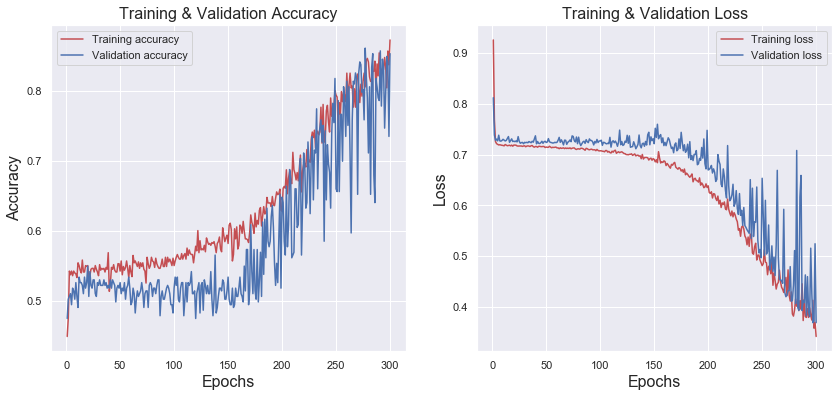

In [16]:
# Fit model and create learning curves for evaluation
# Code source: https://vitalflux.com/python-keras-learning-validation-curve-classification-model/

history = model.fit(X_train_scaled, y_train,
                    validation_data=(X_val_scaled, y_val),
                    epochs=300,
                    batch_size=5)

history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']
 
epochs = range(1, len(loss_values) + 1)
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
#
# Plot the model accuracy vs Epochs
#
ax[0].plot(epochs, accuracy, 'r', label='Training accuracy')
ax[0].plot(epochs, val_accuracy, 'b', label='Validation accuracy')
ax[0].set_title('Training & Validation Accuracy', fontsize=16)
ax[0].set_xlabel('Epochs', fontsize=16)
ax[0].set_ylabel('Accuracy', fontsize=16)
ax[0].legend()
#
# Plot the loss vs Epochs
#
ax[1].plot(epochs, loss_values, 'r', label='Training loss') 
ax[1].plot(epochs, val_loss_values, 'b', label='Validation loss')
ax[1].set_title('Training & Validation Loss', fontsize=16)
ax[1].set_xlabel('Epochs', fontsize=16)
ax[1].set_ylabel('Loss', fontsize=16)
ax[1].legend()

In [17]:
# Final fit of model based on info from learning curves
# Uses keras.callbacks.EarlyStopping to prevent overfitting
# callback code from: https://www.tensorflow.org/guide/keras/train_and_evaluate

callbacks = [
    keras.callbacks.EarlyStopping(
        monitor = "val_loss",
        min_delta=1e-2,
        patience=5,
        verbose=1,
    )
]

model.fit(X_train_scaled, y_train, batch_size=5, callbacks=callbacks, validation_split=0.2, epochs=200) # work in early stopping

Epoch 1/200
122/122 [==============================] - 0s 4ms/step - loss: 0.3911 - accuracy: 0.8399 - val_loss: 0.4248 - val_accuracy: 0.7697
Epoch 2/200
122/122 [==============================] - 0s 3ms/step - loss: 0.3781 - accuracy: 0.8300 - val_loss: 0.3007 - val_accuracy: 0.8750
Epoch 3/200
122/122 [==============================] - 0s 3ms/step - loss: 0.3721 - accuracy: 0.8581 - val_loss: 0.2918 - val_accuracy: 0.8684
Epoch 4/200
122/122 [==============================] - 0s 2ms/step - loss: 0.3819 - accuracy: 0.8449 - val_loss: 0.4676 - val_accuracy: 0.7500
Epoch 5/200
122/122 [==============================] - 0s 3ms/step - loss: 0.3851 - accuracy: 0.8317 - val_loss: 0.2974 - val_accuracy: 0.8421
Epoch 6/200
122/122 [==============================] - 0s 4ms/step - loss: 0.3728 - accuracy: 0.8449 - val_loss: 0.2768 - val_accuracy: 0.9013
Epoch 7/200
122/122 [==============================] - 0s 3ms/step - loss: 0.3452 - accuracy: 0.8597 - val_loss: 0.2791 - val_accuracy: 0.9276

In [18]:
# Evalute model

model_loss, model_accuracy = model.evaluate(X_test_scaled, y_test, verbose=0)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

Loss: 0.4399079382419586, Accuracy: 0.8181818127632141


In [19]:
# Create array of predicted values using X_test_scaled as input

predicted = model.predict_classes(X_test_scaled)
predicted

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


array([1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0,
       0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1,
       1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1,
       0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0,
       1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0,
       0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0,
       0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1,
       0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0], dtype=int64)

In [20]:
# Create dataframe of predicted values

predicteddf = pd.DataFrame(predicted)
predicteddf['dates']=X_test.index
predicteddf.set_index(['dates'], drop=True, inplace=True)
predicteddf = predicteddf.rename(columns={0:"Predicted Values"})
predicteddf.head()

,Predicted Values
dates,
2018-05-15,1
2020-05-18,0
2019-03-07,0
2017-09-14,0
2016-05-25,0


In [21]:
# Use np.argmax to return actual values and create dataframe of actual values

ytest = np.argmax(y_test, axis=1)
realytest = pd.DataFrame(ytest)
realytest['dates']=X_test.index
realytest.set_index(['dates'], drop=True, inplace=True)
realytest = realytest.rename(columns={0:"Actual Values"})
realytest.head()

,Actual Values
dates,
2018-05-15,1
2020-05-18,0
2019-03-07,0
2017-09-14,0
2016-05-25,0


In [22]:
# Concatenate actual and predicted into on dataset

results = pd.concat([predicteddf,realytest], axis=1)
results.head()

,Predicted Values,Actual Values
dates,,
2018-05-15,1,1
2020-05-18,0,0
2019-03-07,0,0
2017-09-14,0,0
2016-05-25,0,0


In [23]:
# Calculate final accuracy score

print("Accuracy: %.2f" % (accuracy_score(predicteddf, realytest)))


Accuracy: 0.82


In [24]:
# Calculate classification report

print(classification_report(predicteddf, realytest)) 

              precision    recall  f1-score   support

           0       0.99      0.71      0.83       157
           1       0.69      0.99      0.81        96
           2       0.00      0.00      0.00         0

    accuracy                           0.82       253
   macro avg       0.56      0.57      0.55       253
weighted avg       0.88      0.82      0.82       253

